In [1]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import math
from keras.layers import Dense, Input, CuDNNLSTM, Embedding, Dropout, Activation,TimeDistributed
from keras.layers import Bidirectional, LSTM
from keras.layers import Input, Embedding, Dense, Conv2D, MaxPool2D, concatenate,BatchNormalization,MaxPooling1D, Convolution1D
from keras.layers import Reshape, Flatten, Concatenate, Dropout, SpatialDropout1D, RepeatVector, Permute, merge
from keras import backend as K
from keras import layers
from keras.models import Sequential, Model

Using TensorFlow backend.


In [26]:
MAX_SEQUENCE_LENGTH = 5000
MAX_NUM_WORDS = 25000
EMBEDDING_DIM = 300
TEST_SPLIT = 0.3
EMBEDDING_FILE=f'glove.6B.{EMBEDDING_DIM}d.txt'
TEXT_DATA = 'data/fake_or_real_news.csv'

In [3]:
# estimate 95% confidence interval on error

# NOTE: based on conversation on stackexchange: 
# https://stats.stackexchange.com/questions/247551/how-to-determine-the-confidence-of-a-neural-network-prediction
# towards bottom of the page.

from math import sqrt

def error_conf(error, n):
    term = 1.96*sqrt((error*(1-error))/n)
    lb = error - term
    ub = error + term
    
    return lb, ub

In [4]:
# define a function that allows us to evaluate our models

from sklearn.metrics import accuracy_score

def evaluate_model(predict_fun, X_train, y_train, X_test, y_test):
    '''
    evaluate the model, both training and testing errors are reported
    '''
    # training error
    y_predict_train = predict_fun(X_train)
    train_acc = accuracy_score(y_train,y_predict_train)
    
    # testing error
    y_predict_test = predict_fun(X_test)
    test_acc = accuracy_score(y_test,y_predict_test)
    
    return train_acc, test_acc

In [5]:
# read in our data and preprocess it

df = pd.read_csv(TEXT_DATA)
df.drop(labels=['id','title'], axis='columns', inplace=True)
# only select stories with lengths gt 0 -- there are some texts with len = 0
mask = list(df['text'].apply(lambda x: len(x) > 0))
df = df[mask]

In [6]:
# prepare text samples and their labels

texts = df['text']
labels = df['label']

print('Found %s texts.' %texts.shape[0])

Found 6335 texts.


## Convolutional DNN

In [7]:
# vectorize the text samples into a 2D integer tensor 
import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
num_words = min(MAX_NUM_WORDS, len(word_index)) + 1
data = pad_sequences(sequences, 
                     maxlen=MAX_SEQUENCE_LENGTH, 
                     padding='pre', 
                     truncating='pre')

print('Found %s unique tokens.' % len(word_index))
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

Found 99682 unique tokens.
Shape of data tensor: (6335, 5000)
Shape of label tensor: (6335,)


In [8]:
# Read the glove word vectors (space delimited strings) into a dictionary from word->vector.

def get_coefs(word,*arr): return word, np.asarray(arr, dtype='float32')
embeddings_index = dict(get_coefs(*o.strip().split()) for o in open(EMBEDDING_FILE, encoding="utf8"))

In [9]:
# Use these vectors to create our embedding matrix, with random initialization for words that aren't in GloVe. We'll use the same mean and stdev of embeddings the GloVe has when generating the random init

all_embs = np.stack(embeddings_index.values())
emb_mean,emb_std = all_embs.mean(), all_embs.std()
emb_mean,emb_std

word_index = tokenizer.word_index
nb_words = min(MAX_NUM_WORDS, len(word_index))
embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, EMBEDDING_DIM))
for word, i in word_index.items():
    if i >= MAX_NUM_WORDS: continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: embedding_matrix[i] = embedding_vector

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  This is separate from the ipykernel package so we can avoid doing imports until


In [27]:
# split the data into a training set and a validation set   

from sklearn.model_selection import train_test_split

x_train, x_val, y_train, y_val = train_test_split(data, 
                                                  labels.apply(lambda x: 0 if x == 'FAKE' else 1), 
                                                  test_size=TEST_SPLIT)

In [11]:
def f1(y_true, y_pred):
    '''
    metric from here 
    https://stackoverflow.com/questions/43547402/how-to-calculate-f1-macro-in-keras
    '''
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    
    # So we only measure F1 on the target y value:
    y_true = y_true[:, 0]
    y_pred = y_pred[:, 0]
    
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2 * ((precision * recall) / (precision + recall + K.epsilon()))

In [12]:
# # build a 1D convnet with global maxpooling                                                                      


# model = Sequential(
#     [
#         # part 1: word and sequence processing
#         layers.Embedding(MAX_NUM_WORDS,
#                          EMBEDDING_DIM,
#                          input_length=MAX_SEQUENCE_LENGTH,
#                          weights=[embedding_matrix]),
#         layers.Conv1D(128, 5, activation='relu'),
#         layers.GlobalMaxPooling1D(),
        
#         # part 2: classification
#         layers.Dense(128, activation='relu'),
#         layers.Dense(1, activation='sigmoid')
#     ])

# model.compile(loss='binary_crossentropy',
#               optimizer='rmsprop',
#               metrics=['accuracy'])

# model.summary()

In [13]:
dropout_prob = [0.2,0.2]
hidden_dims = 50
filter_sizes  = (3,8)
num_filters = 10
BATCH_SIZE = 32

input_shape = (MAX_SEQUENCE_LENGTH,)
model_input = Input(shape=input_shape)



z = Embedding(MAX_NUM_WORDS,
              EMBEDDING_DIM,
              weights=[embedding_matrix],
              input_length=MAX_SEQUENCE_LENGTH)(model_input)

conv_blocks = []
for sz in filter_sizes:
    conv = Convolution1D(filters=num_filters,
                         kernel_size=sz,
                         padding="valid",
                         activation="relu",
                         strides=1)(z)
    conv = MaxPooling1D(pool_size=2)(conv)
    conv = Flatten()(conv)
    conv_blocks.append(conv)
z = Concatenate()(conv_blocks) if len(conv_blocks) > 1 else conv_blocks[0]

z = Dropout(dropout_prob[1])(z)
z = Dense(hidden_dims, activation="relu")(z)
model_output = Dense(1, activation="sigmoid")(z)

model = Model(model_input, model_output)
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy",f1])

print(model.summary())


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 5000)         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 5000, 300)    7500000     input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 4998, 10)     9010        embedding_1[0][0]                
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 4993, 10)     24010       embedding_1[0][0]              

In [14]:

# training
TRAINING_BATCH_SIZE      = 64
# TRAINING_SHUFFLE_BUFFER  = 5000
# TRAINING_BN_MOMENTUM     = 0.99
# TRAINING_BN_EPSILON      = 0.001
TRAINING_LR_MAX          = 0.001
# TRAINING_LR_SCALE        = 0.1
# TRAINING_LR_EPOCHS       = 2
TRAINING_LR_INIT_SCALE   = 0.01
TRAINING_LR_INIT_EPOCHS  = 3
TRAINING_LR_FINAL_SCALE  = 0.01
TRAINING_LR_FINAL_EPOCHS = 7

# training (derived)
TRAINING_NUM_EPOCHS = TRAINING_LR_INIT_EPOCHS + TRAINING_LR_FINAL_EPOCHS
TRAINING_LR_INIT    = TRAINING_LR_MAX*TRAINING_LR_INIT_SCALE
TRAINING_LR_FINAL   = TRAINING_LR_MAX*TRAINING_LR_FINAL_SCALE

# saving
SAVE_MODEL_PATH = './save/model/gloveCNN/'
!mkdir -p "$SAVE_MODEL_PATH"

A subdirectory or file -p already exists.
Error occurred while processing: -p.
A subdirectory or file ./save/model/gloveCNN/ already exists.
Error occurred while processing: ./save/model/gloveCNN/.


In [15]:
def lr_schedule(epoch):

    # staircase
    # lr = TRAINING_LR_MAX*math.pow(TRAINING_LR_SCALE, math.floor(epoch/TRAINING_LR_EPOCHS))

    # linear warmup followed by cosine decay
    if epoch < TRAINING_LR_INIT_EPOCHS:
        lr = (TRAINING_LR_MAX - TRAINING_LR_INIT)*(float(epoch)/TRAINING_LR_INIT_EPOCHS) + TRAINING_LR_INIT
    else:
        lr = ((TRAINING_LR_MAX - TRAINING_LR_FINAL)*
              max(0.0, math.cos(((float(epoch) - TRAINING_LR_INIT_EPOCHS)/
                                 (TRAINING_LR_FINAL_EPOCHS - 1.0))*(math.pi/2.0))) + 
              TRAINING_LR_FINAL)

    # debug - learning rate display
    # print(epoch)
    # print(lr)

    return lr

In [28]:
# train the model
callbacks = [keras.callbacks.LearningRateScheduler(lr_schedule),
             keras.callbacks.ModelCheckpoint(filepath=SAVE_MODEL_PATH+'model_{epoch}.h5', 
                                             save_best_only=True, monitor='val_loss', verbose=1)]

initial_epoch_num = 0
# example of restarting training after a crash from the last saved checkpoint
# model.load_weights(SAVE_MODEL_PATH+'model_5.h5') # replace X with the last saved checkpoint number
# initial_epoch_num = 5                            # replace X with the last saved checkpoint number


history           = model.fit(x_train, 
                              y_train,shuffle=True,batch_size=TRAINING_BATCH_SIZE,
                              epochs=TRAINING_NUM_EPOCHS, 
                              verbose=1, 
                              callbacks=callbacks, 
                              validation_data=(x_val, y_val), 
                              initial_epoch=initial_epoch_num)

# previous version with 97% testing accuracy
# history = model.fit(x_train, 
#                     y_train,
#                     batch_size=128,
#                     epochs=10,
#                     validation_data=(x_val, y_val))

Train on 4434 samples, validate on 1901 samples
Epoch 1/10
4434/4434 [==============================] - 274s 62ms/step - loss: 0.0711 - accuracy: 0.9831 - f1: 0.9821 - val_loss: 0.0943 - val_accuracy: 0.9847 - val_f1: 0.9840

Epoch 00001: val_loss improved from inf to 0.09426, saving model to ./save/model/gloveCNN/model_1.h5
Epoch 2/10
4434/4434 [==============================] - 303s 68ms/step - loss: 0.0609 - accuracy: 0.9869 - f1: 0.9869 - val_loss: 0.0427 - val_accuracy: 0.9911 - val_f1: 0.9902

Epoch 00002: val_loss improved from 0.09426 to 0.04270, saving model to ./save/model/gloveCNN/model_2.h5
Epoch 3/10
4434/4434 [==============================] - 329s 74ms/step - loss: 0.0183 - accuracy: 0.9966 - f1: 0.9968 - val_loss: 0.0511 - val_accuracy: 0.9911 - val_f1: 0.9903

Epoch 00003: val_loss did not improve from 0.04270
Epoch 4/10
4434/4434 [==============================] - 306s 69ms/step - loss: 0.0099 - accuracy: 0.9991 - f1: 0.9991 - val_loss: 0.0807 - val_accuracy: 0.9868 -

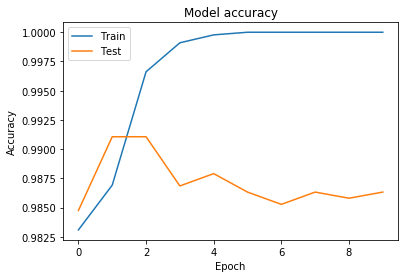

In [30]:
# Plot training & validation accuracy values
# print(history.history)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [18]:
# model.load_weights(SAVE_MODEL_PATH+'model_5.h5')

In [19]:
# evaluate model

def predict(X):
    return np.rint(model.predict(X)) # threshold the predictions to retrieve labels

train_acc, test_acc = evaluate_model(predict,
                                     x_train, 
                                     y_train, 
                                     x_val, 
                                     y_val)
print("Training Accuracy: {:.2f}%".format(train_acc*100))
print("Testing Accuracy: {:.2f}%".format(test_acc*100))

Training Accuracy: 100.00%
Testing Accuracy: 96.81%


In [20]:
# estimate 95% confidence interval

n = x_val.shape[0]
lb, ub = error_conf(1-test_acc, n)

print("confidence interval: {:.2f}%-{:.2f}%".format((1-ub)*100,(1-lb)*100))

confidence interval: 96.20%-97.42%


In [21]:
# df['label']
